# в файле ML-7 с 3. Продвинутая оптимизация

In [2]:
#импорт библиотек
import numpy as np #для матричных вычислений
import pandas as pd #для анализа и предобработки данных
import matplotlib.pyplot as plt #для визуализации
import seaborn as sns #для визуализации

from sklearn import linear_model #линейные моделиё
from sklearn import tree #деревья решений
from sklearn import ensemble #ансамбли
from sklearn import metrics #метрики
from sklearn import preprocessing #предобработка
from sklearn.model_selection import train_test_split #сплитование выборки

%matplotlib inline
plt.style.use('seaborn')

C:\Users\qwaiv\AppData\Local\Temp\ipykernel_15832\2150022218.py:15: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')


In [3]:
#ЕСЛИ РАБОТАЕМ В IDE
data = pd.read_csv('data/adult.csv')

#ЕСЛИ РАБОТАЕМ В GOOGLE COLAB
# подключаем google диск, где у нас хранятся данные
# from google.colab import drive
# drive.mount('/content/drive')
# # берем необходимый нам файл с диска, указав путь
# data = pd.read_csv('./drive/MyDrive/SF/SF module 7/adult.csv')
data.head()

,age,workclass,fnlwgt,education,education.num,marital.status,occupation,relationship,race,sex,capital.gain,capital.loss,hours.per.week,native.country,income
0,90,?,77053,HS-grad,9,Widowed,?,Not-in-family,White,Female,0,4356,40,United-States,<=50K
1,82,Private,132870,HS-grad,9,Widowed,Exec-managerial,Not-in-family,White,Female,0,4356,18,United-States,<=50K
2,66,?,186061,Some-college,10,Widowed,?,Unmarried,Black,Female,0,4356,40,United-States,<=50K
3,54,Private,140359,7th-8th,4,Divorced,Machine-op-inspct,Unmarried,White,Female,0,3900,40,United-States,<=50K
4,41,Private,264663,Some-college,10,Separated,Prof-specialty,Own-child,White,Female,0,3900,40,United-States,<=50K


In [4]:
data['income'] = data['income'].apply(lambda x: 1 if x == '>50K' else 0)

In [5]:
adult_data = data.copy()
#Определяем школьников в отдельную категорию
adult_data['education'] = adult_data['education'].apply(
    lambda x: 'School' if x == '11th' or x == '7th-8th' or x == '10th' 
        or x == '5th-6th' or x == '9th' or x == '12th' or x == '1st-4th' else x
)
#Объединяем категории Assoc-acdm и Assoc-voc (доценты)
adult_data['education'] = adult_data['education'].apply(
    lambda x: 'Associate' if x == 'Assoc-acdm' or x == 'Assoc-voc' else x
)
#Объединяем вдовцов,разведенных и живущих раздельно в одну категорию
adult_data['marital.status'] = adult_data['marital.status'].apply(
    lambda x: 'Prev-Married' if (x == 'Widowed' or x == 'Divorced' or x == 'Separated') else x
)
#Объединяем всех женатых/за мужем в одну категорию
adult_data['marital.status'] = adult_data['marital.status'].apply(
    lambda x: 'Married' if (x == 'Married-civ-spouse' or x == 'Married-spouse-absent' or x == 'Married-AF-spouse') else x
)
#Объединяем мужей и жен в одну категорию, остальных в другую
adult_data['relationship'] = adult_data['relationship'].apply(
    lambda x: 'In relationship' if (x == 'Husband' or x == 'Whife') else 'Not in relationship'
)

#Объединяем типы занятоностей, не приносящих дохода в одну категорию
adult_data['workclass'] = adult_data['workclass'].apply(
    lambda x: 'No income' if x == 'Never-worked' or x == 'Without-pay' else x
)
#Объединяем всех приезжих в одну категорию
adult_data['native.country'] = adult_data['native.country'].apply(
    lambda x: 'Other' if x != 'United-States' else x
)

In [6]:
#Логарифмируем числовые признаки, чтобы придать им форму нормального распределения
adult_data['capital.gain'] = np.log(adult_data['capital.gain']+1)
adult_data['capital.loss'] = np.log(adult_data['capital.loss']+1)
adult_data['fnlwgt'] = np.log(adult_data['fnlwgt']+1)

#Создаем новый признак - разность между приростом капитала и его убылью
adult_data['capital_diff'] = abs((adult_data['capital.gain'] - adult_data['capital.loss']))

In [7]:
#Удаляем лишние признаки
adult_data = adult_data.drop(['education.num', 'capital.gain', 'capital.loss'], axis=1)

In [8]:
dummies_data = pd.get_dummies(adult_data, drop_first=True)
dummies_data.head()

,age,fnlwgt,hours.per.week,income,capital_diff,workclass_Federal-gov,workclass_Local-gov,workclass_No income,workclass_Private,workclass_Self-emp-inc,...,occupation_Sales,occupation_Tech-support,occupation_Transport-moving,relationship_Not in relationship,race_Asian-Pac-Islander,race_Black,race_Other,race_White,sex_Male,native.country_United-States
0,90,11.252262,40,0,8.379539,0,0,0,0,0,...,0,0,0,1,0,0,0,1,0,1
1,82,11.797134,18,0,8.379539,0,0,0,1,0,...,0,0,0,1,0,0,0,1,0,1
2,66,12.133835,40,0,8.379539,0,0,0,0,0,...,0,0,0,1,0,1,0,0,0,1
3,54,11.851966,40,0,8.268988,0,0,0,1,0,...,0,0,0,1,0,0,0,1,0,1
4,41,12.486216,40,0,8.268988,0,0,0,1,0,...,0,0,0,1,0,0,0,1,0,1


In [9]:
X = dummies_data.drop(['income'], axis=1)
y = dummies_data['income']

In [10]:
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state = 1, test_size = 0.2)

In [11]:
scaler = preprocessing.MinMaxScaler()
scaler.fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [12]:
#Создаем объект класса случайный лес
rf = ensemble.RandomForestClassifier(random_state=42)

#Обучаем модель
rf.fit(X_train_scaled, y_train)
#Выводим значения метрики 
y_train_pred = rf.predict(X_train_scaled)
print('Train: {:.2f}'.format(metrics.f1_score(y_train, y_train_pred)))
y_test_pred = rf.predict(X_test_scaled)
print('Test: {:.2f}'.format(metrics.f1_score(y_test, y_test_pred)))

Train: 1.00
Test: 0.66


[link](https://apps.skillfactory.ru/learning/course/course-v1:SkillFactory+DST-3.0+28FEB2021/block-v1:SkillFactory+DST-3.0+28FEB2021+type@sequential+block@f380e1eed0db437a9295f74d6f7ba74f/block-v1:SkillFactory+DST-3.0+28FEB2021+type@vertical+block@662a4dbd6147440d8b026e804c46ab36)

Оценка качества модели для каждой комбинации гиперпараметров является дорогостоящей частью оптимизации — на приведённых крохотных сетках по нескольким параметрам это занимает минуты, но в реальных масштабах это занимает часы и сутки. Поэтому в идеале мы хотим оптимизировать гиперпараметры самым эффективным образом. 

Один из способов  — это байесовская оптимизация. Она отличается от случайного поиска или поиска по сетке тем, что учитывает предыдущие результаты, а не выбирает комбинации из вариантов, не имеющих информации о прошлых оценках. Во многих случаях это позволяет найти лучшие значения гиперпараметров модели за меньшее количество времени. Таким образом, мы получаем и более быструю оптимизацию, и более качественный результат. Это два желаемых результата, особенно когда мы работаем с настройкой гиперпараметров моделей МО.

Существует несколько разных алгоритмов для этого типа оптимизации, но особенно используемым является Tree-Structured Parzen Estimators (TPE).

TREE-STRUCTURED PARZEN ESTIMATORS (TPE)

1. На каждой итерации алгоритм TPE учитывает информацию о прошлых опробованных комбинациях гиперпараметров и только потом принимает решение, какой набор следует попробовать дальше. 

Чтобы приступить к использованию TPE, необходимо выполнить несколько итераций с помощью случайного поиска. 

2. На следующем шаге происходит разделение собранных наборов на две группы:

* в первую группу входят наборы, дающие наилучшие результаты после оценки;
* во вторую — все остальные.

На изображении ниже: первая группа — красные точки находятся в области минимума целевой функции; вторая группа — синие точки, все остальные.

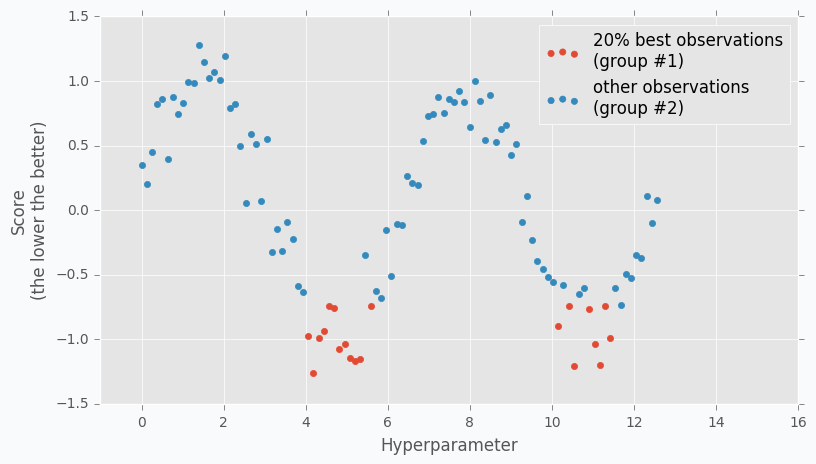

Основная цель алгоритма — найти набор гиперпараметров, который с большей вероятностью будет в первой группе и с меньшей вероятностью во второй группе. Таким образом, для принятия следующего решения используется целое распределение наилучших комбинаций — красные точки на графике.

3. Далее TPE моделирует вероятности правдоподобия для каждой из групп, используя формулу Байеса:

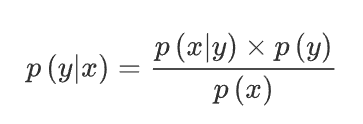

где X — гиперпараметры, y — соответствующая оценка качества модели.

4. Затем, используя вероятность правдоподобия из первой группы, отбирается набор комбинаций, которые с большей вероятностью попадут в первую группу и с меньшей вероятностью — во вторую. 

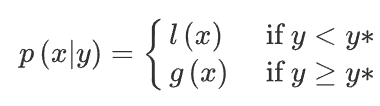

где p(x|y) — это вероятность гиперпараметров с учётом оценки целевой функции, l(x) — вероятность быть в первой группе, g(x) — вероятность быть во второй группе

Определяем ожидаемое улучшение для каждой комбинации:

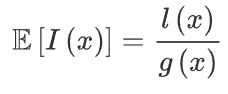

* где E — это знак математического ожидания.

5. Шаги 2-4  будет выполняться до тех пор, пока не будет достигнуто максимальное количество итераций. 

В итоге мы найдём наилучшую комбинацию гиперпараметров.

Более подробное описание алгоритма с математическими выкладками вы можете найти [здесь](https://academy.yandex.ru/handbook/ml/article/podbor-giperparametrov).

### <center> Hyperopt

3.5 Реализуйте настройку гиперпараметров алгоритма RandomForestClassifier(random_state=42) со следующей сеткой значений:

* n_estimators = от 100 до 300 включительно с шагом 10
* min_samples_leaf = от 3 до 7 с шагом 1
* max_depth = от 15 до 40 с шагом 1

Используйте Hyperopt с параметрами max_evals = 20.

В ответе укажите метрику f1 на тестовой выборке, значение округлите до двух знаков после запятой (например, 0.58).

Впишите в поле не знаю ответ, если хотите увидеть эталонное решение.

In [13]:
#делаем импорт и выведем версию библиотеки
from sklearn.model_selection import cross_val_score
import hyperopt
from hyperopt import hp, fmin, tpe, Trials
# fmin - основная функция, она будет минимизировать наш функционал
# tpe - алгоритм оптимизации
# hp - включает набор методов для объявления пространства поиска гиперпараметров
# trails - используется для логирования результатов

print("Версия Hyperopt : {}".format(hyperopt.__version__))

Версия Hyperopt : 0.2.7


In [14]:
# зададим пространство поиска гиперпараметров
space={'n_estimators': hp.quniform('n_estimators', 100, 301, 10),
       'max_depth' : hp.quniform('max_depth', 3, 7, 1),
       'min_samples_leaf': hp.quniform('min_samples_leaf', 15, 40, 1)
      }

In [15]:
# зафксируем random_state
random_state = 42
def hyperopt_rf(params, cv=5, X=X_train_scaled, y=y_train, random_state=random_state):
    # функция получает комбинацию гиперпараметров в "params"
    params = {'n_estimators': int(params['n_estimators']), 
              'max_depth': int(params['max_depth']), 
             'min_samples_leaf': int(params['min_samples_leaf'])
              }
  
    # используем эту комбинацию для построения модели
    model = ensemble.RandomForestClassifier(**params, random_state=random_state)

    # обучаем модель
    model.fit(X, y)
    score = metrics.f1_score(y, model.predict(X))
    
    # обучать модель можно также с помощью кросс-валидации
    # применим  cross validation с тем же количеством фолдов
    # score = cross_val_score(model, X, y, cv=cv, scoring="f1", n_jobs=-1).mean()

    # метрику необходимо минимизировать, поэтому ставим знак минус
    return -score

In [17]:
%%time
# начинаем подбор гиперпараметров

trials = Trials() # используется для логирования результатов

best=fmin(hyperopt_rf, # наша функция 
          space=space, # пространство гиперпараметров
          algo=tpe.suggest, # алгоритм оптимизации, установлен по умолчанию, задавать необязательно
          max_evals=20, # максимальное количество итераций
          trials=trials, # логирование результатов
          rstate=np.random.default_rng(random_state)# фиксируем для повторяемости результата
         )
print("Наилучшие значения гиперпараметров {}".format(best))

  0%|          | 0/20 [00:00<?, ?trial/s, best loss=?]

100%|██████████| 20/20 [00:57<00:00,  2.85s/trial, best loss: -0.5896987766012131]
Наилучшие значения гиперпараметров {'max_depth': 7.0, 'min_samples_leaf': 33.0, 'n_estimators': 190.0}
CPU times: total: 36.4 s
Wall time: 57 s


In [18]:
# рассчитаем точность для тестовой выборки
model = ensemble.RandomForestClassifier(
    random_state=random_state, 
    n_estimators=int(best['n_estimators']),
    max_depth=int(best['max_depth']),
    min_samples_leaf=int(best['min_samples_leaf'])
)
model.fit(X_train_scaled, y_train)
y_train_pred = model.predict(X_train_scaled)
y_test_pred = model.predict(X_test_scaled)
print('f1_score на тестовом наборе: {:.2f}'.format(metrics.f1_score(y_test, y_test_pred)))

f1_score на тестовом наборе: 0.60


## <center> Optuna

3.10 Реализуйте настройку гиперпараметров алгоритма RandomForestClassifier(random_state=42) со следующей сеткой значений:

n_estimators = от 100 до 300 включительно с шагом 10
min_samples_leaf = от 3 до 7 с шагом 1
max_depth = от 15 до 40 с шагом 1
Используйте Optuna с параметрами n_trails = 20.

В ответе укажите метрику f1 на тестовой выборке, значение округлите до двух знаков после запятой (например, 0.58).

Впишите в поле не знаю ответ, если хотите увидеть эталонное решение.

In [19]:
import optuna

print("Версия Optuna: {}".format(optuna.__version__))

d:\Program Files\Python311\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Версия Optuna: 3.2.0


In [23]:
def optuna_rf(trial):
  # задаем пространства поиска гиперпараметров
  n_estimators = trial.suggest_int('n_estimators', 100, 301, 10)
  max_depth = trial.suggest_int('max_depth', 15, 40, 1)
  min_samples_leaf = trial.suggest_int('min_samples_leaf', 3, 7, 1)

  # создаем модель
  model = ensemble.RandomForestClassifier(n_estimators=n_estimators,
                                          max_depth=max_depth,
                                          min_samples_leaf=min_samples_leaf,
                                          random_state=random_state)
  # обучаем модель
  model.fit(X_train_scaled, y_train)
  score = metrics.f1_score(y_train, model.predict(X_train_scaled))

  return score
  
  

In [24]:
%%time
# cоздаем объект исследования
# можем напрямую указать, что нам необходимо максимизировать метрику direction="maximize"
study = optuna.create_study(study_name="RandomForestClassifier", direction="maximize")
# ищем лучшую комбинацию гиперпараметров n_trials раз
study.optimize(optuna_rf, n_trials=20)

[I 2023-07-26 20:50:05,519] A new study created in memory with name: RandomForestClassifier
d:\Program Files\Python311\Lib\site-packages\optuna\distributions.py:700: UserWarning: The distribution is specified by [100, 301] and step=10, but the range is not divisible by `step`. It will be replaced by [100, 300].
  warnings.warn(
[I 2023-07-26 20:50:11,862] Trial 0 finished with value: 0.7019248395967004 and parameters: {'n_estimators': 150, 'max_depth': 20, 'min_samples_leaf': 6}. Best is trial 0 with value: 0.7019248395967004.
d:\Program Files\Python311\Lib\site-packages\optuna\distributions.py:700: UserWarning: The distribution is specified by [100, 301] and step=10, but the range is not divisible by `step`. It will be replaced by [100, 300].
  warnings.warn(
[I 2023-07-26 20:50:16,530] Trial 1 finished with value: 0.7177441291141536 and parameters: {'n_estimators': 100, 'max_depth': 23, 'min_samples_leaf': 5}. Best is trial 1 with value: 0.7177441291141536.
d:\Program Files\Python311

CPU times: total: 1min 48s
Wall time: 3min


In [25]:
# рассчитаем точность для тестовой выборки
model = ensemble.RandomForestClassifier(**study.best_params,random_state=random_state, )
model.fit(X_train_scaled, y_train)
y_train_pred = model.predict(X_train_scaled)
print("accuracy на тестовом наборе: {:.2f}".format(model.score(X_test_scaled, y_test)))
y_test_pred = model.predict(X_test_scaled)
print('f1_score на тестовом наборе: {:.2f}'.format(metrics.f1_score(y_test, y_test_pred)))

accuracy на тестовом наборе: 0.86
f1_score на тестовом наборе: 0.68


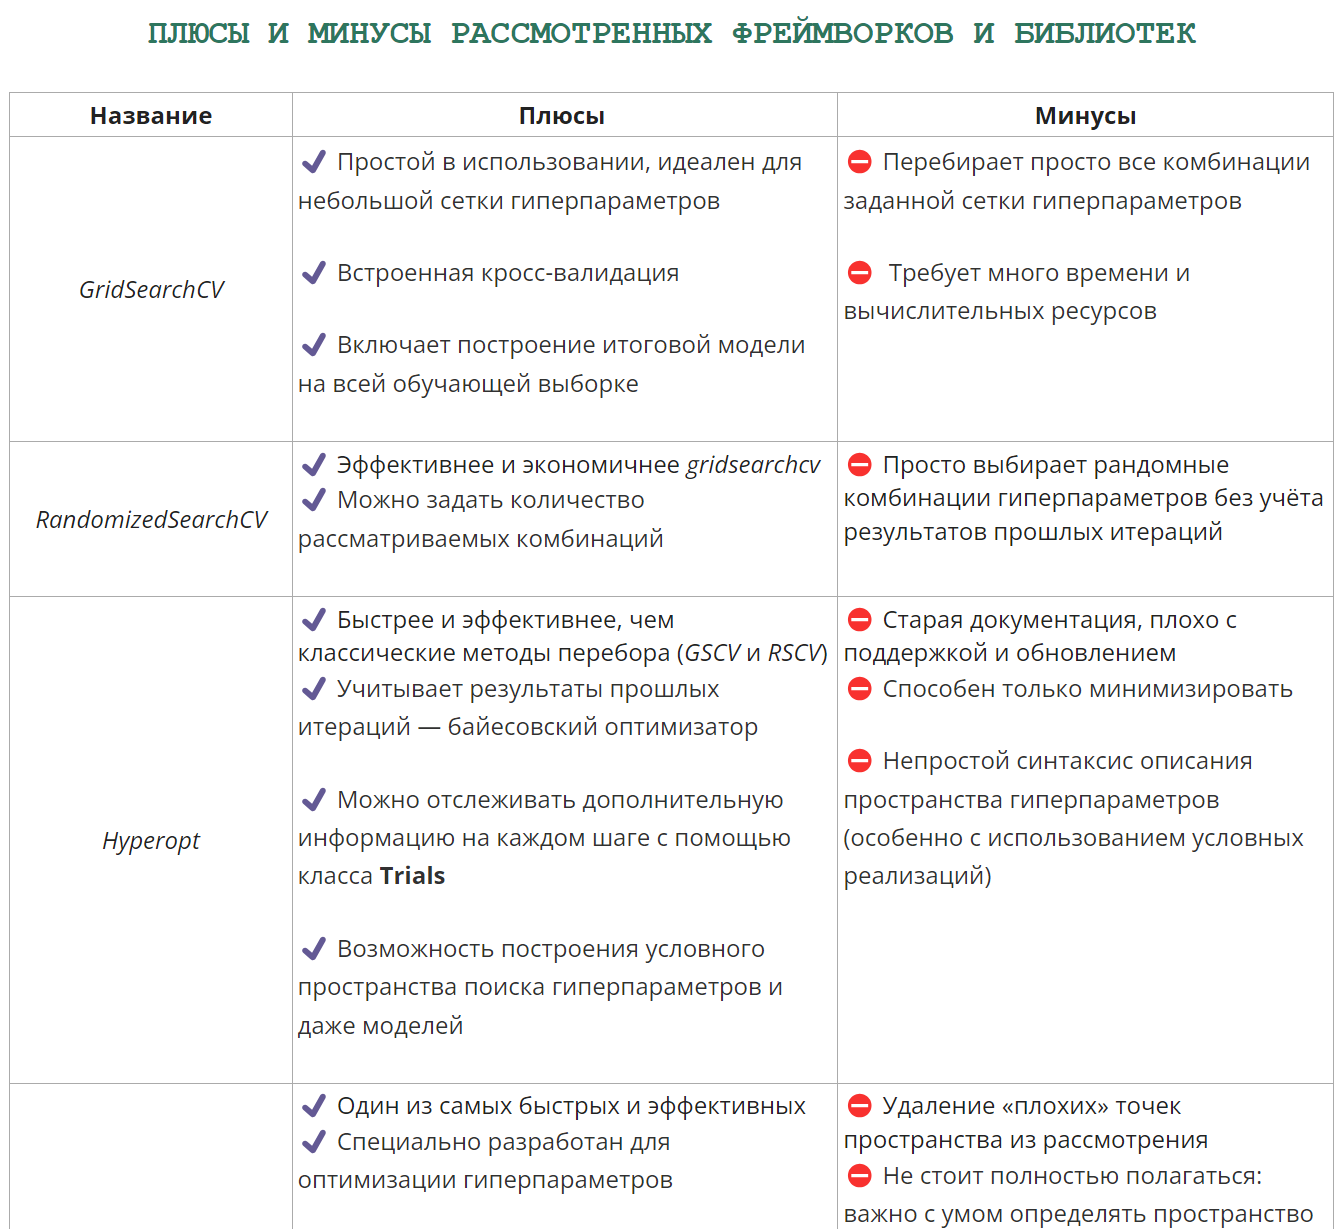
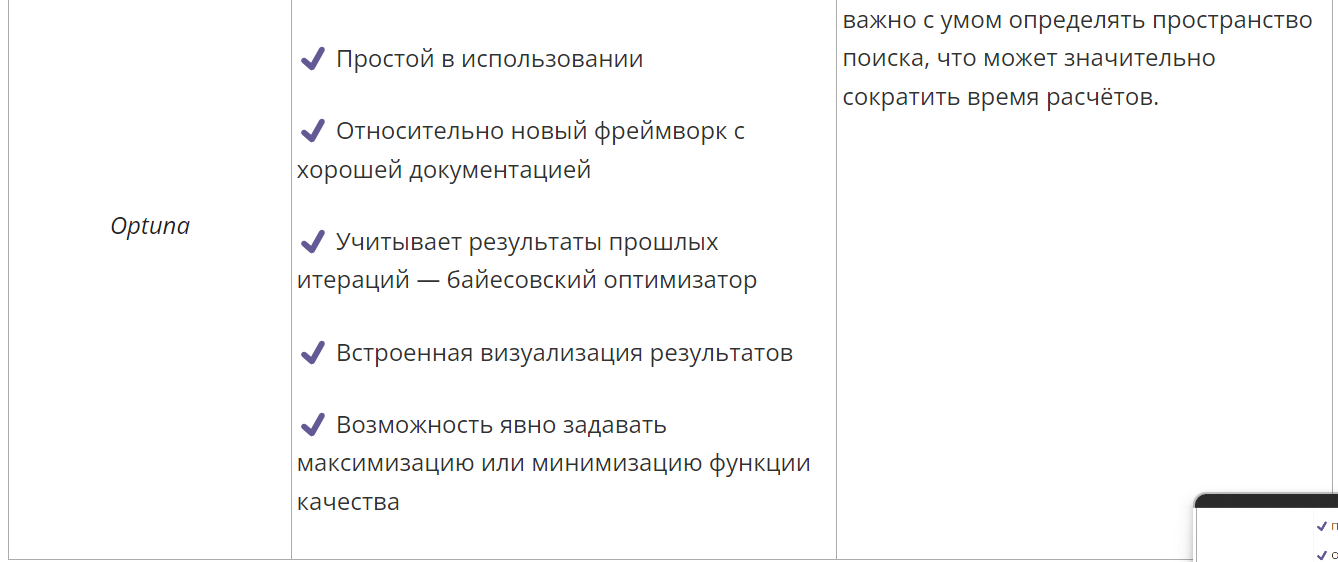